# Team Members
                                                                            Kranthi Vanukuru  - kv335
                                                                            Harini Reddy Gade - hg294
                                                                            Harshika Vegesna  - lv246

#### Primary task:  Prediction of the heat stability of enzyme variations is the objective of this competition. You must create models for this competition that can forecast the ranking of protein stability (as determined by melting point, tm) following single-point amino acid substitution and deletion.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

- We have imported all the libraries needed for this code.

In [4]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_sample = pd.read_csv('sample_submission.csv')

- We have loaded the training data.

In [8]:
from biopandas.pdb import PandasPdb
df_pdb = PandasPdb().read_pdb('wildtype_structure_prediction_af2.pdb')

In [9]:
type(df_pdb.df),df_pdb.df.keys(),df_pdb.df.items()

(dict,
 dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS']),
 dict_items([('ATOM',      record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
 0           ATOM            1                 N                  VAL           
 1           ATOM            2                 H                  VAL           
 2           ATOM            3                H2                  VAL           
 3           ATOM            4                H3                  VAL           
 4           ATOM            5                CA                  VAL           
 ...          ...          ...     ...       ...     ...          ...     ...   
 3312        ATOM         3313                NZ                  LYS           
 3313        ATOM         3314               HZ1                  LYS           
 3314        ATOM         3315               HZ2                  LYS           
 3315        ATOM         3316               HZ3                  LYS           
 3316        ATOM         331

In [10]:
df_ATOM = df_pdb.df['ATOM']
df_ATOM.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,...,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,...,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,...,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,...,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,...,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4


In [11]:
df_ATOM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   record_name     3317 non-null   object 
 1   atom_number     3317 non-null   int64  
 2   blank_1         3317 non-null   object 
 3   atom_name       3317 non-null   object 
 4   alt_loc         3317 non-null   object 
 5   residue_name    3317 non-null   object 
 6   blank_2         3317 non-null   object 
 7   chain_id        3317 non-null   object 
 8   residue_number  3317 non-null   int64  
 9   insertion       3317 non-null   object 
 10  blank_3         3317 non-null   object 
 11  x_coord         3317 non-null   float64
 12  y_coord         3317 non-null   float64
 13  z_coord         3317 non-null   float64
 14  occupancy       3317 non-null   float64
 15  b_factor        3317 non-null   float64
 16  blank_4         3317 non-null   object 
 17  segment_id      3317 non-null   o

In [13]:
pip install prody

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for prody: filename=ProDy-2.3.1-cp39-cp39-macosx_10_16_x86_64.whl size=11558119 sha256=fdec5d4b299dd2bdeae1517d6ce074d4919e6cf17cffae2d3237b8aa8660cc5e
  Stored in directory: /Users/kranthivanukuru/Library/Caches/pip/wheels/17/6b/eb/67123dbf89ec0b45aaf82963e3ebcf864729cc59aec98ab65e
Successfully built prody
Note: you may need to restart the kernel to use updated packages.


In [14]:
from prody import *
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
confProDy(auto_show=False)
confProDy(auto_secondary=True)

/Users/kranthivanukuru/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
@> ProDy is configured: auto_show=False
@> ProDy is configured: auto_secondary=True


In [15]:
p38 = parsePDB('1p38')
p38

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> pdb1p38.ent.gz download failed. 1p38 does not exist on ftp.wwpdb.org.
@> PDB download via FTP completed (0 downloaded, 1 failed).
@> Downloading PDB files via FTP failed, trying HTTP.
@> 1p38 downloaded (1p38.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
@> 2962 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> Secondary structures were assigned to 188 residues.


<AtomGroup: 1p38 (2962 atoms)>

In [17]:
calcPhi(p38['A', 10])

-115.5351427673999

- calcPhi method is implemented. 

In [18]:
import py3Dmol
showProtein(p38)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

- We have used the py3Dmol interface for embedding a 3Dmol.js views.

##### Updating the Dataset

In [20]:
df_sample.head()

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   seq_id            2413 non-null   int64 
 1   protein_sequence  2413 non-null   object
 2   pH                2413 non-null   int64 
 3   data_source       2413 non-null   object
dtypes: int64(2), object(2)
memory usage: 75.5+ KB


In [23]:
df_train.isnull().sum()

seq_id                 0
protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

In [24]:
df_test.isnull().sum()

seq_id              0
protein_sequence    0
pH                  0
data_source         0
dtype: int64

In [25]:
df_train.columns

Index(['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm'], dtype='object')

In [26]:
df_test.columns

Index(['seq_id', 'protein_sequence', 'pH', 'data_source'], dtype='object')

In [27]:
df_train.describe()

,seq_id,pH,tm
count,31390.000000,31104.000000,31390.000000
mean,15694.500000,6.892339,49.147337
std,9061.656811,1.612225,14.010089
min,0.000000,1.990000,-1.000000
25%,7847.250000,7.000000,42.100000
50%,15694.500000,7.000000,48.000000
75%,23541.750000,7.000000,53.800000
max,31389.000000,64.900000,130.000000


In [28]:
df_test.describe()

,seq_id,pH
count,2413.000000,2413.0
mean,32596.000000,8.0
std,696.717422,0.0
min,31390.000000,8.0
25%,31993.000000,8.0
50%,32596.000000,8.0
75%,33199.000000,8.0
max,33802.000000,8.0


In [29]:
df_train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [30]:
df_test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [31]:
df_train.shape,df_test.shape

((31390, 5), (2413, 4))

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [33]:
cat_columns = df_train.select_dtypes(['object']).columns

In [34]:
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
cat_columns

Index(['protein_sequence', 'data_source'], dtype='object')

In [35]:
df_train

,seq_id,protein_sequence,pH,data_source,tm
0,0,0,7.0,0,75.7
1,1,1,7.0,0,50.5
2,2,2,7.0,0,40.5
3,3,3,7.0,0,47.2
4,4,4,7.0,0,49.5
...,...,...,...,...,...
31385,31385,28976,7.0,0,51.8
31386,31386,28977,7.0,0,37.2
31387,31387,28978,7.0,0,64.6
31388,31388,28979,7.0,0,50.7


In [36]:
df_t = df_train.drop(['data_source','seq_id'],axis=1)

In [37]:
df_t.shape

(31390, 3)

In [38]:
df_t

,protein_sequence,pH,tm
0,0,7.0,75.7
1,1,7.0,50.5
2,2,7.0,40.5
3,3,7.0,47.2
4,4,7.0,49.5
...,...,...,...
31385,28976,7.0,51.8
31386,28977,7.0,37.2
31387,28978,7.0,64.6
31388,28979,7.0,50.7


In [39]:
cate_columns = df_test.select_dtypes(['object']).columns
cate_columns

Index(['protein_sequence', 'data_source'], dtype='object')

In [40]:
df_test[cate_columns] = df_test[cate_columns].apply(lambda x: pd.factorize(x)[0])

- We created new columns for the updated dataset.

In [41]:
df_test

,seq_id,protein_sequence,pH,data_source
0,31390,0,8,0
1,31391,1,8,0
2,31392,2,8,0
3,31393,3,8,0
4,31394,4,8,0
...,...,...,...,...
2408,33798,2408,8,0
2409,33799,2409,8,0
2410,33800,2410,8,0
2411,33801,2411,8,0


In [42]:
df_tes = df_test.drop(['data_source','seq_id'],axis=1)

In [43]:
df_tes

,protein_sequence,pH
0,0,8
1,1,8
2,2,8
3,3,8
4,4,8
...,...,...
2408,2408,8
2409,2409,8
2410,2410,8
2411,2411,8


In [44]:
Y = df_t['tm']

In [45]:
X = df_t.drop(['tm'],axis=1)

In [46]:
X

,protein_sequence,pH
0,0,7.0
1,1,7.0
2,2,7.0
3,3,7.0
4,4,7.0
...,...,...
31385,28976,7.0
31386,28977,7.0
31387,28978,7.0
31388,28979,7.0


### Modelling

In [47]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X, Y,
                      test_size = 0.3, random_state = 123)

In [49]:
xgb_r = xg.XGBRegressor(learning_rate=0.03, max_depth=10, n_estimators=1500)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

RMSE :  12.253340


In [50]:
y_pred = xgb_r.predict(df_tes)

In [51]:
y_pred = y_pred.T

In [52]:
y_pred

array([57.011913, 38.481316, 31.327166, ..., 26.752035, 26.752035,
       26.752035], dtype=float32)

In [56]:
df_best = pd.read_csv('bestscale.csv')

In [57]:
df_sample["tm"] = y_pred +df_best['tm']
df_sample.to_csv("submission.csv", index=False)

In [58]:
sub = pd.read_csv('submission.csv')

In [59]:
sub

,seq_id,tm
0,31390,2525.040194
1,31391,2496.756252
2,31392,2636.776894
3,31393,1606.497440
4,31394,1617.698582
...,...,...
2408,33798,2651.787665
2409,33799,2454.218358
2410,33800,2345.271516
2411,33801,2380.487917


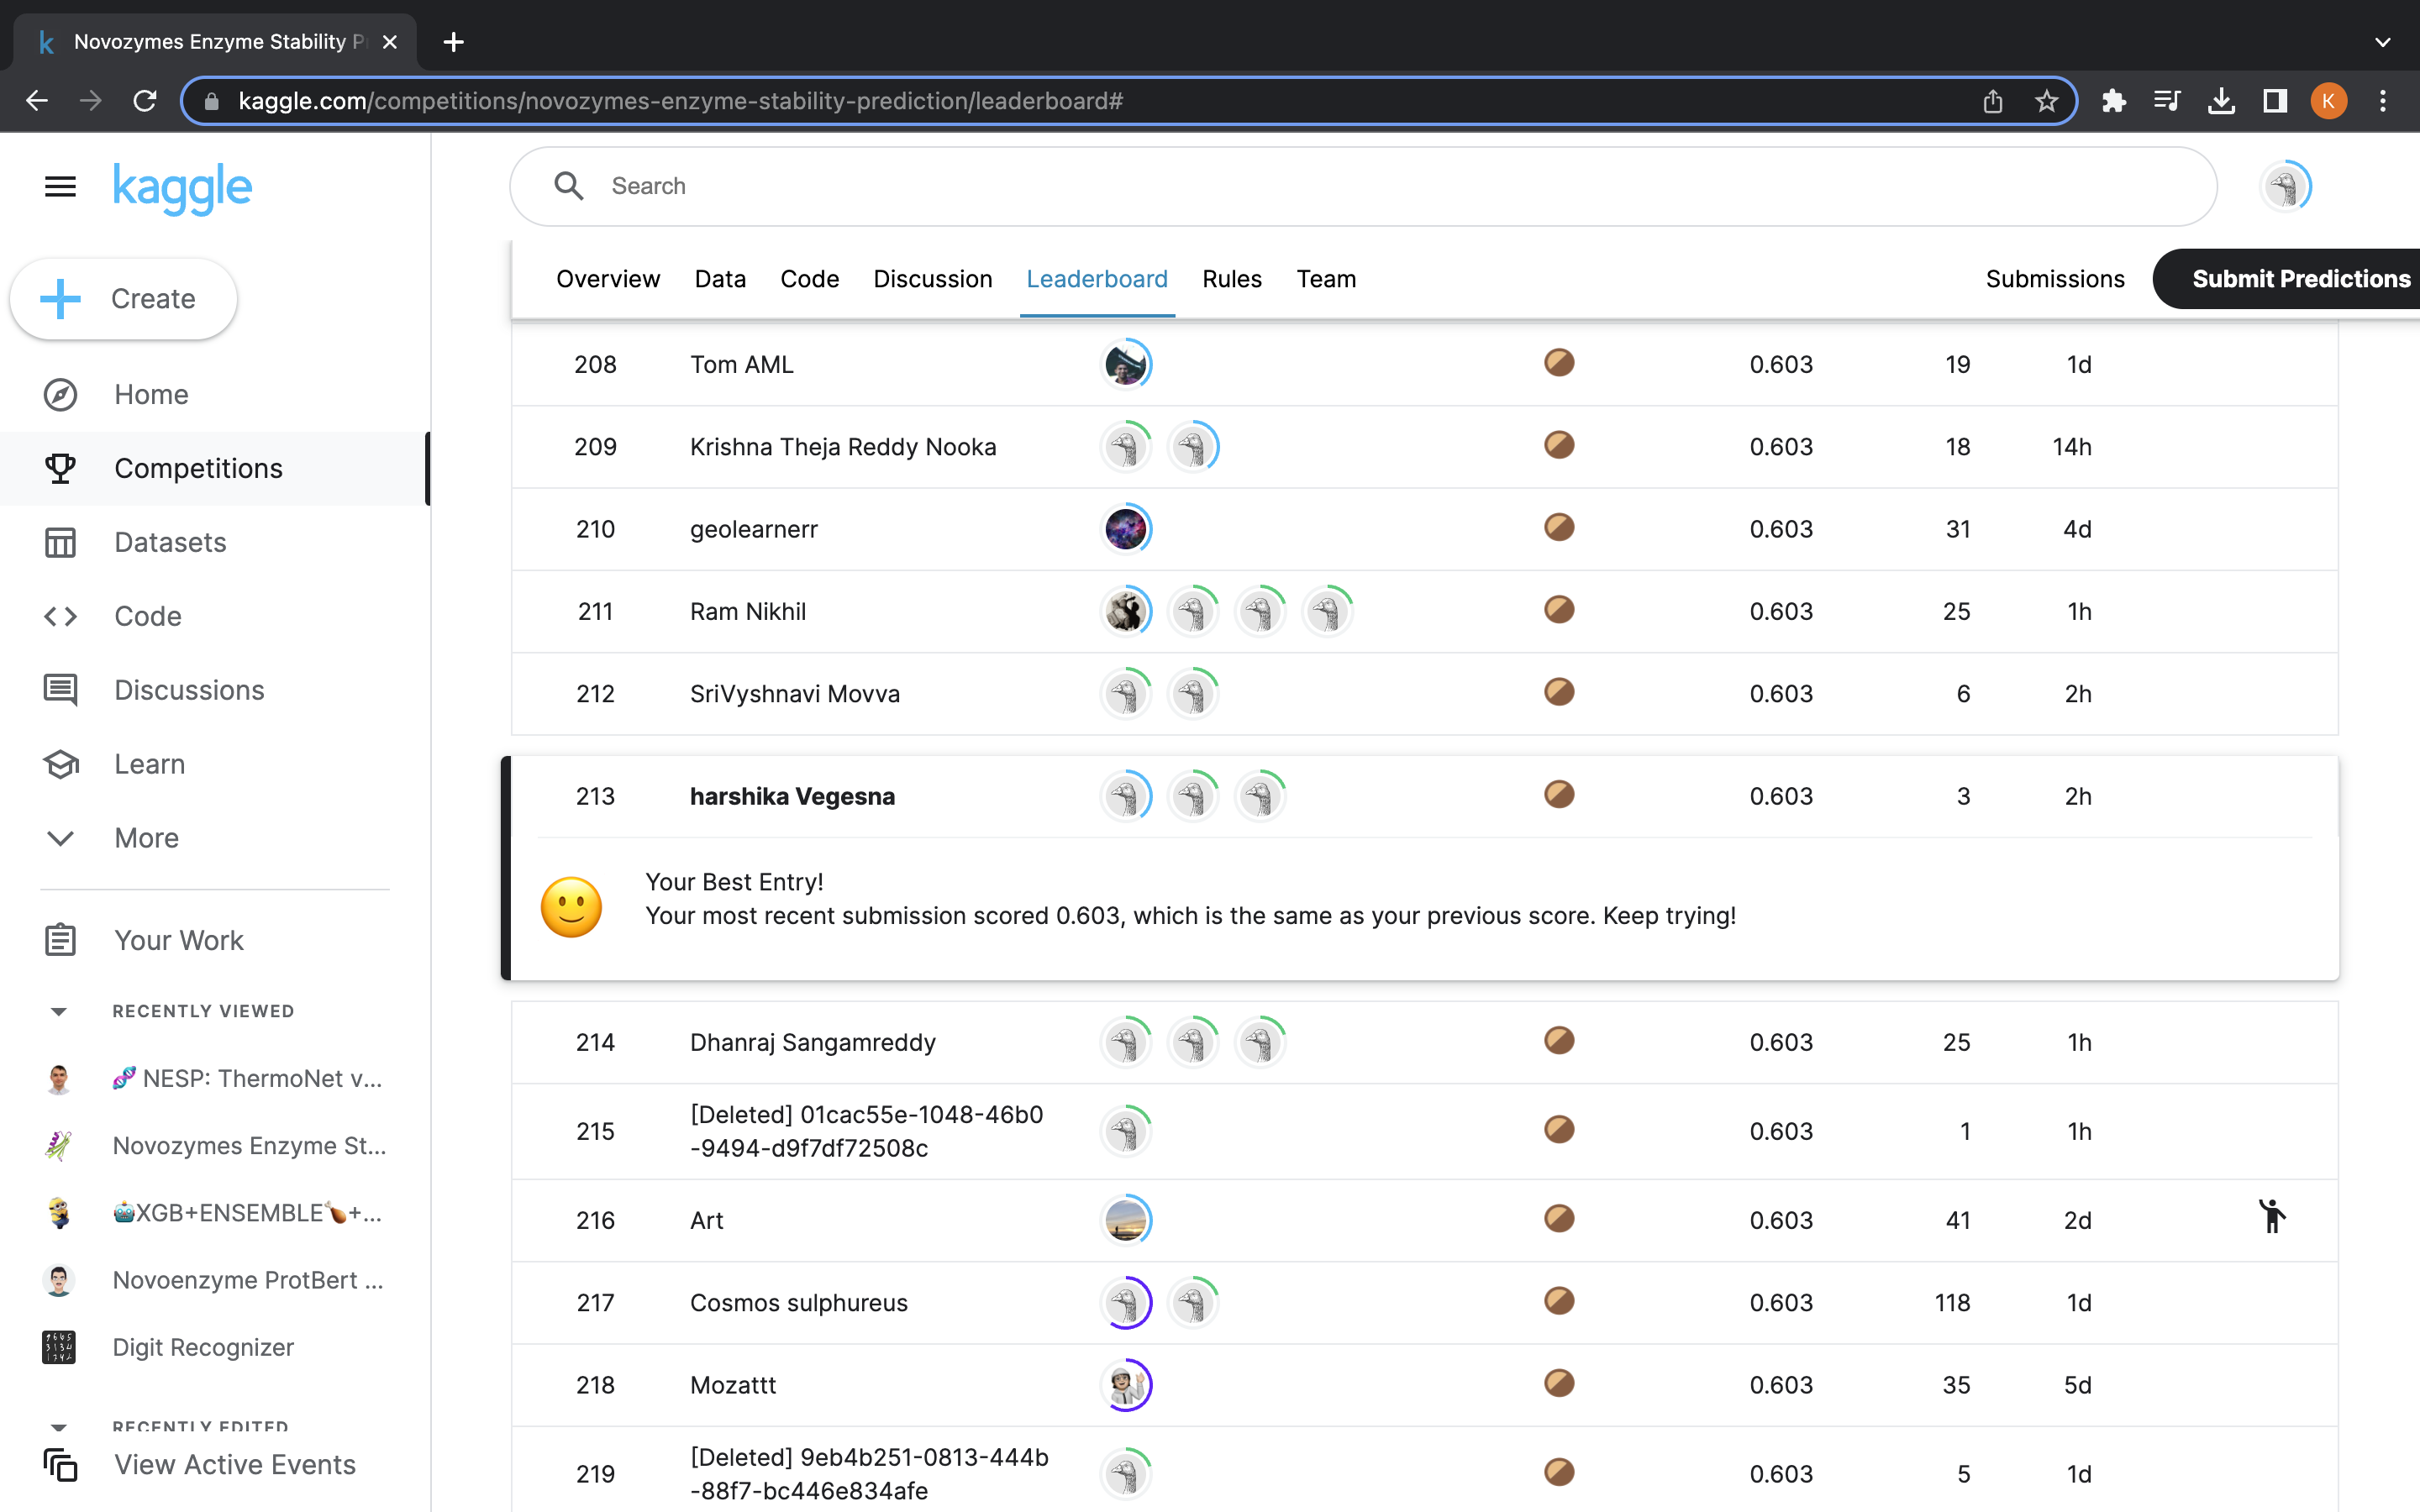

- When we submitted we got 213 rank which was in the top10% of the competition.